# OCR精度評価（サンプル調査 / 29件 / 2025-12-02実施分）

各OCRモデルの出力をground_truthと比較し、精度を評価します。

## 評価指標
- **CER (Character Error Rate)**: 文字単位の誤り率
- **完全一致率**: ground_truthと完全に一致する割合

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import japanize_matplotlib
import unicodedata
import re

# Levenshtein距離計算用
try:
    import Levenshtein
except ImportError:
    print("Levenshteinライブラリをインストールしてください: pip install python-Levenshtein")

## データ読み込み

In [2]:
# CSVファイルのパス
csv_path = Path("../output/20251202-0942/extracted/combined_texts_with_gt.csv")

# CSVを読み込み（マルチライン対応）
df = pd.read_csv(csv_path, encoding='utf-8')

# ヘッダーを除く1〜29行目を取得（0-indexedで0〜28行目）
df = df.iloc[:29].copy()

print(f"読み込んだ行数: {len(df)}")
print(f"列名: {df.columns.tolist()}")
df.head()

読み込んだ行数: 29
列名: ['filename', 'azure', 'upstage', 'yomitoku', 'ground_truth', 'iLabo']


,filename,azure,upstage,yomitoku,ground_truth,iLabo
0,ja_pii_handwriting_0001,外山茉梨愛知県豊川市赤坂町東裏林コーポ952号室 昭和52年07月13日 03-5945-6185,外山 茉梨 愛知県豊 川 市赤坂 町 東裏 林コーポ 952号室 昭和52年07月13日 0...,外山菜梨愛知県豊川市赤坂町東裏林コーポ952号室 昭和52年07月13日 03-5945-6185,外山茉梨 愛知県豊川市赤坂町東裏 林コーポ952号室 昭和52年07月13日 03-5945...,外山茉梨愛知県豊川市赤坂町東裏林ーポ９５２号室昭和５２年０７月１３日０３－５４５－６１８５
1,ja_pii_handwriting_0002,桑本政言 岩手県紫波郡紫波町平沢槽41番地-15号 529.02.04 058-705-3003,pr 桑本政言 岩手県紫波郡紫波 町平沢檜 41番地 - 15号 S29. 02.04 05...,桑本政言 岩手県被郡紫波町平沢檜41番地-15号 529.02.04 058-705-3003,桑本政言 岩手県紫波郡紫波町平沢檜 41番地-15号 S29.02.04 058-705-3003,川\r\n桑本政言岩手県紫波郡紫波町平沢檜４１番地－１５号３２９０２０４０５８－７０５－０３
2,ja_pii_handwriting_0003,買紗織北海道砂川市吉野一条南三丁目8-59-9 2002年06月22日 058-784-4941,覧 紗織 北海道砂川 市吉 野 一条南三丁目8-59-9 2002年06月22日 058- ...,買紗織 北海道加市吉野一条南三丁目8-19-9 200年06月22日 058-084-4941,筧紗織 北海道砂川市吉野一条南三丁目8-59-9 2002年06月22日 058-784-4941,筧紗織北海道砂川市吉野一条南汀丁目８－５９－９２００年０６月２２日０５８０８４－４９４１
3,ja_pii_handwriting_0004,治田美智 大阪府井野市高橋四丁目佐々木エクセル棟189号室1950年04月07日 03-40...,治田 美笹 大阪府羽曳野 市 高鷲四丁目 佐々木エクセル 棟 189号室 1970年04月0...,im活田美世 大阪府羽曳野市高鷲四丁目 依木工クセレン棟189号室 110年04月07日 2...,治田美笹 大阪府羽曳野市高鷲四丁目 佐々木エクセルC棟189号室 1970年04月07日 0...,治田美笹大阪羽野市高鷲町丁目佐々木ジル棟１８９愛多知多多タ３如３７８
4,ja_pii_handwriting_0005,釣太見夫 和歌山県伊都郡かつらぎ町大字東渋田橋本メゾン737号室 昭和48年01月30日09...,··· 釣 太見夫 和歌山県伊弥閣をかつうぎ町大学東 渋田 橋本メゾン 737 号室 昭和 ...,釣 太見夫 和歌山県伊都郡かつらぎ町大字東渋田橋本メゾン737号室 昭和48年01月30日 ...,釣 太見夫 和歌山県伊都郡かつらぎ町大字東渋田 橋本メゾン737号室 昭和48年01月30日...,釣太見夫和歌山県伊都郡かつらぎ町大字東渋田橋本メゾン７３７号空昭和４８年０１月３０日０９０－...


In [3]:
# 比較対象のモデル列
model_columns = ['azure', 'upstage', 'yomitoku', 'iLabo']
ground_truth_column = 'ground_truth'

# 欠損値を空文字に置換
for col in model_columns + [ground_truth_column]:
    df[col] = df[col].fillna('').astype(str)

print("データの前処理完了")

データの前処理完了


## 評価関数の定義

### 前処理 (normalize_text)
1. 改行除去
2. NFKC正規化（全角数字・記号→半角）
3. 先頭のノイズ文字除去（`···`, `pr`, `im`等）
4. 全スペース除去（半角・全角）← オプションで切替可能

### 評価指標
- **CER (Character Error Rate)**: `編集距離 / ground_truthの文字数`
- **CER (スペース除去前)**: スペースを保持した状態でのCER
- **CER (スペース除去後)**: スペースを除去した状態でのCER
- **exact_match**: 正規化後のテキストが完全一致するか判定

In [4]:
# 先頭のノイズパターン（OCRのゴミ文字）
NOISE_PATTERNS = [
    r'^[·\.]{2,}\s*',      # 連続するドット
    r'^pr\s+',              # "pr "
    r'^im\s*',              # "im"
    r'^inc\s*',             # "inc"
    r'^int\s*',             # "int"
    r'^\d{3}\s+',           # 先頭の3桁数字+スペース (例: "111 ")
]

def normalize_text(text: str, remove_spaces: bool = True) -> str:
    """テキストの正規化（強化版）
    
    Args:
        text: 入力テキスト
        remove_spaces: Trueならスペースを除去、Falseなら連続スペースを1つに統一
    
    処理内容:
        1. 改行を除去
        2. NFKC正規化（全角→半角変換）
        3. 先頭のノイズ文字を除去
        4. スペース処理（除去 or 統一）
    """
    if pd.isna(text):
        return ''
    
    text = str(text)
    
    # 1. 改行を除去
    text = text.replace('\n', '').replace('\r', '')
    
    # 2. NFKC正規化（全角数字・記号を半角に変換）
    text = unicodedata.normalize('NFKC', text)
    
    # 3. 先頭のノイズパターンを除去
    for pattern in NOISE_PATTERNS:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # 4. スペース処理
    if remove_spaces:
        # すべてのスペースを除去（半角・全角両方）
        text = text.replace(' ', '').replace('\u3000', '')
        text = re.sub(r'\s+', '', text)
    else:
        # 連続するスペースを1つに統一
        text = re.sub(r'[\s\u3000]+', ' ', text).strip()
    
    return text

def calculate_cer(prediction: str, ground_truth: str, remove_spaces: bool = True) -> float:
    """Character Error Rate (CER) を計算
    
    CER = (置換 + 挿入 + 削除) / ground_truthの文字数
    """
    pred = normalize_text(prediction, remove_spaces=remove_spaces)
    gt = normalize_text(ground_truth, remove_spaces=remove_spaces)
    
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    
    distance = Levenshtein.distance(pred, gt)
    return distance / len(gt)

def exact_match(prediction: str, ground_truth: str, remove_spaces: bool = True) -> bool:
    """完全一致を判定"""
    pred = normalize_text(prediction, remove_spaces=remove_spaces)
    gt = normalize_text(ground_truth, remove_spaces=remove_spaces)
    return pred == gt

# テスト用: 正規化の動作確認
print("正規化テスト:")
test_cases = [
    ("外山 茉梨 愛知県", "外山茉梨愛知県"),
    ("９５２号室", "952号室"),
    ("··· 釣 太見夫", "釣太見夫"),
]
for original, expected in test_cases:
    result_with_space = normalize_text(original, remove_spaces=False)
    result_no_space = normalize_text(original, remove_spaces=True)
    print(f"  原文: '{original}'")
    print(f"    スペース保持: '{result_with_space}'")
    print(f"    スペース除去: '{result_no_space}'")

正規化テスト:
  原文: '外山 茉梨 愛知県'
    スペース保持: '外山 茉梨 愛知県'
    スペース除去: '外山茉梨愛知県'
  原文: '９５２号室'
    スペース保持: '952号室'
    スペース除去: '952号室'
  原文: '··· 釣 太見夫'
    スペース保持: '釣 太見夫'
    スペース除去: '釣太見夫'


## 各モデルの精度算出

In [5]:
# 各行ごとの評価結果を格納（スペース除去前後の両方）
results = []

for idx, row in df.iterrows():
    gt = row[ground_truth_column]
    row_result = {'filename': row['filename']}
    
    for model in model_columns:
        pred = row[model]
        # スペース除去後のCER
        row_result[f'{model}_cer'] = calculate_cer(pred, gt, remove_spaces=True)
        # スペース保持のCER
        row_result[f'{model}_cer_with_space'] = calculate_cer(pred, gt, remove_spaces=False)
        # 完全一致（スペース除去後）
        row_result[f'{model}_exact'] = exact_match(pred, gt, remove_spaces=True)
    
    results.append(row_result)

results_df = pd.DataFrame(results)
print(f"評価完了: {len(results_df)}行")
results_df.head()

評価完了: 29行


,filename,azure_cer,azure_cer_with_space,azure_exact,upstage_cer,upstage_cer_with_space,upstage_exact,yomitoku_cer,yomitoku_cer_with_space,yomitoku_exact,iLabo_cer,iLabo_cer_with_space,iLabo_exact
0,ja_pii_handwriting_0001,0.000000,0.039216,True,0.000000,0.196078,True,0.021277,0.058824,False,0.042553,0.117647,False
1,ja_pii_handwriting_0002,0.044444,0.061224,False,0.000000,0.102041,True,0.066667,0.081633,False,0.133333,0.204082,False
2,ja_pii_handwriting_0003,0.021739,0.040816,False,0.021739,0.142857,False,0.130435,0.122449,False,0.086957,0.142857,False
3,ja_pii_handwriting_0004,0.132075,0.157895,False,0.018868,0.105263,False,0.226415,0.210526,False,0.547170,0.578947,False
4,ja_pii_handwriting_0005,0.000000,0.050000,True,0.090909,0.250000,False,0.018182,0.033333,False,0.018182,0.100000,False


In [6]:
# サマリー統計を計算（スペース除去前後の両方）
summary = {}

for model in model_columns:
    summary[model] = {
        'CER (除去後・平均)': results_df[f'{model}_cer'].mean(),
        'CER (除去後・中央値)': results_df[f'{model}_cer'].median(),
        'CER (除去前・平均)': results_df[f'{model}_cer_with_space'].mean(),
        'CER (除去前・中央値)': results_df[f'{model}_cer_with_space'].median(),
        '完全一致率': results_df[f'{model}_exact'].mean(),
        '完全一致数': results_df[f'{model}_exact'].sum(),
    }

summary_df = pd.DataFrame(summary).T
summary_df.index.name = 'Model'

print("=" * 70)
print("OCR精度評価サマリー")
print("=" * 70)
summary_df

OCR精度評価サマリー


,CER (除去後・平均),CER (除去後・中央値),CER (除去前・平均),CER (除去前・中央値),完全一致率,完全一致数
Model,,,,,,
azure,0.026925,0.020833,0.047026,0.037736,0.448276,13.0
upstage,0.088312,0.021739,0.286410,0.236364,0.275862,8.0
yomitoku,0.055670,0.038462,0.078436,0.070175,0.137931,4.0
iLabo,0.277317,0.133333,0.329436,0.204082,0.000000,0.0


## 結果の可視化

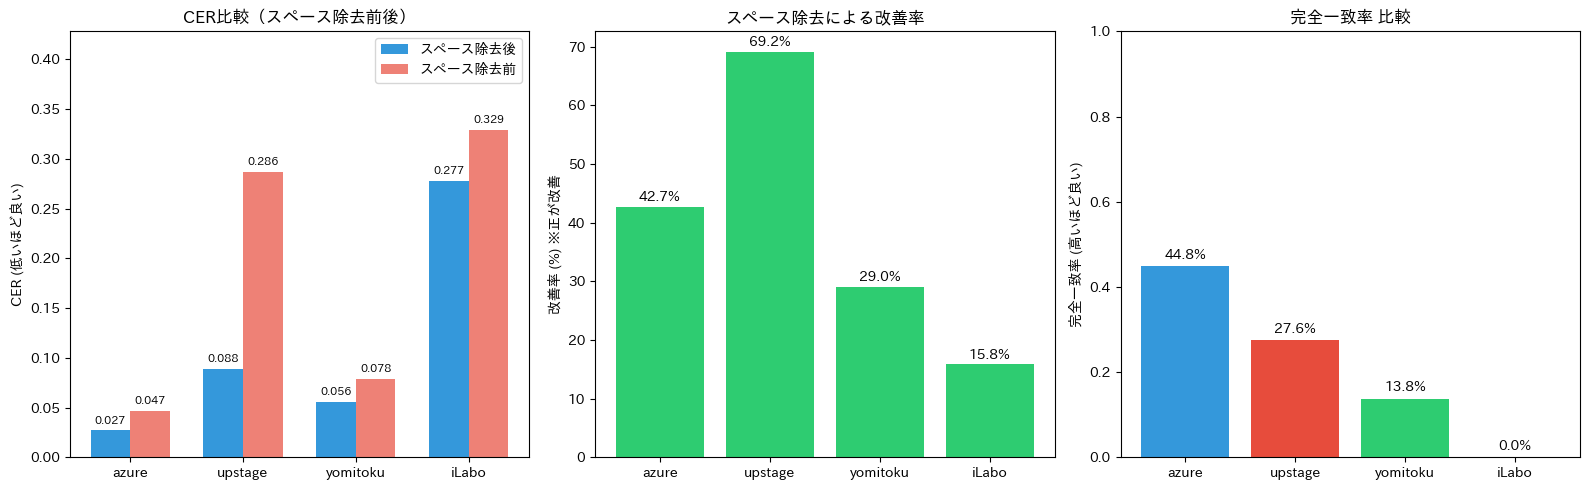

グラフを保存しました: ocr_accuracy_comparison.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# CER比較（スペース除去前後）
ax1 = axes[0]
x = np.arange(len(model_columns))
width = 0.35

cer_after = [summary_df.loc[model, 'CER (除去後・平均)'] for model in model_columns]
cer_before = [summary_df.loc[model, 'CER (除去前・平均)'] for model in model_columns]

bars1 = ax1.bar(x - width/2, cer_after, width, label='スペース除去後', color='#3498db')
bars2 = ax1.bar(x + width/2, cer_before, width, label='スペース除去前', color='#e74c3c', alpha=0.7)

ax1.set_title('CER比較（スペース除去前後）')
ax1.set_ylabel('CER (低いほど良い)')
ax1.set_xticks(x)
ax1.set_xticklabels(model_columns)
ax1.legend()
ax1.set_ylim(0, max(max(cer_after), max(cer_before)) * 1.3)

for bar, val in zip(bars1, cer_after):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, cer_before):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)

# CER改善率（スペース除去による改善）
ax2 = axes[1]
improvement = [(before - after) / before * 100 if before > 0 else 0 
               for before, after in zip(cer_before, cer_after)]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvement]
bars3 = ax2.bar(model_columns, improvement, color=colors)
ax2.set_title('スペース除去による改善率')
ax2.set_ylabel('改善率 (%) ※正が改善')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

for bar, val in zip(bars3, improvement):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

# 完全一致率比較
ax3 = axes[2]
exact_values = [summary_df.loc[model, '完全一致率'] for model in model_columns]
bars4 = ax3.bar(model_columns, exact_values, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
ax3.set_title('完全一致率 比較')
ax3.set_ylabel('完全一致率 (高いほど良い)')
ax3.set_ylim(0, 1.0)

for bar, val in zip(bars4, exact_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../output/20251202-0942/extracted/ocr_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("グラフを保存しました: ocr_accuracy_comparison.png")

## 詳細結果の出力

In [8]:
# 各行ごとのCERを表形式で表示
cer_detail = results_df[['filename'] + [f'{m}_cer' for m in model_columns]].copy()
cer_detail.columns = ['filename'] + model_columns

print("各ファイルごとのCER (Character Error Rate)")
print("=" * 60)
cer_detail.style.background_gradient(cmap='RdYlGn_r', subset=model_columns)

各ファイルごとのCER (Character Error Rate)


,filename,azure,upstage,yomitoku,iLabo
0,ja_pii_handwriting_0001,0.000000,0.000000,0.021277,0.042553
1,ja_pii_handwriting_0002,0.044444,0.000000,0.066667,0.133333
2,ja_pii_handwriting_0003,0.021739,0.021739,0.130435,0.086957
3,ja_pii_handwriting_0004,0.132075,0.018868,0.226415,0.547170
4,ja_pii_handwriting_0005,0.000000,0.090909,0.018182,0.018182
5,ja_pii_handwriting_0006,0.000000,0.140000,0.080000,0.240000
6,ja_pii_handwriting_0007,0.000000,0.000000,0.018182,0.036364
7,ja_pii_handwriting_0008,0.129630,0.240741,0.092593,0.277778
8,ja_pii_handwriting_0009,0.019608,0.058824,0.196078,0.235294
9,ja_pii_handwriting_0010,0.058824,0.019608,0.098039,0.176471


In [9]:
# 完全一致の詳細
exact_detail = results_df[['filename'] + [f'{m}_exact' for m in model_columns]].copy()
exact_detail.columns = ['filename'] + model_columns

print("各ファイルごとの完全一致 (True=一致, False=不一致)")
print("=" * 60)
exact_detail.style.applymap(lambda x: 'background-color: #90EE90' if x else 'background-color: #FFB6C1', 
                            subset=model_columns)

各ファイルごとの完全一致 (True=一致, False=不一致)


/var/folders/75/829b2bn56z50f7qvkfx05k1w0000gn/T/ipykernel_49384/4246007147.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  exact_detail.style.applymap(lambda x: 'background-color: #90EE90' if x else 'background-color: #FFB6C1',


,filename,azure,upstage,yomitoku,iLabo
0,ja_pii_handwriting_0001,True,True,False,False
1,ja_pii_handwriting_0002,False,True,False,False
2,ja_pii_handwriting_0003,False,False,False,False
3,ja_pii_handwriting_0004,False,False,False,False
4,ja_pii_handwriting_0005,True,False,False,False
5,ja_pii_handwriting_0006,True,False,False,False
6,ja_pii_handwriting_0007,True,True,False,False
7,ja_pii_handwriting_0008,False,False,False,False
8,ja_pii_handwriting_0009,False,False,False,False
9,ja_pii_handwriting_0010,False,False,False,False


In [10]:
# 結果をCSVに保存
output_path = Path("../output/20251202-0942/extracted/ocr_accuracy_results.csv")
results_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"詳細結果を保存しました: {output_path}")

# サマリーもCSVに保存
summary_path = Path("../output/20251202-0942/extracted/ocr_accuracy_summary.csv")
summary_df.to_csv(summary_path, encoding='utf-8')
print(f"サマリーを保存しました: {summary_path}")

詳細結果を保存しました: ../output/20251202-0942/extracted/ocr_accuracy_results.csv
サマリーを保存しました: ../output/20251202-0942/extracted/ocr_accuracy_summary.csv
